# Load libraries

In [2]:
import numpy as np 
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten

import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2 

In [3]:
# Loading test and training target dataset
base_dir = "G:/Mon Drive/"

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Loading

In [4]:
im_size = 150
im_size1 = im_size
im_size2 = im_size

def append_ext(fn):
    return fn+".jpg"

df_train = pd.read_csv(base_dir + "dataset/dbfinal_train_NOupsample.csv", dtype=str)
df_train.head() 
#df_train.level = df_train.level.to_string()
df_train["img_name"]=df_train["img_name"].apply(append_ext)

datagen = ImageDataGenerator(horizontal_flip=True, 
                            zoom_range=[0.85,1],
                            rotation_range=0,
                            brightness_range=[0.4,1])
train_ds = datagen.flow_from_dataframe(dataframe=df_train,
    directory=base_dir+'dataset/train/denoiseCLAHE/',
    x_col='img_name',
    y_col="level",
    batch_size=128,
    seed=2022,
    shuffle=True,
    class_mode="categorical",
    target_size=(im_size, im_size2)) 

 
df_val = pd.read_csv(base_dir + "dataset/dbfinal_test_NOupsample.csv", dtype=str)
df_val["level"] = df_val["level"].astype(str)
df_val["img_name"]=df_val["img_name"].apply(append_ext)

datagen = ImageDataGenerator()
val_ds = datagen.flow_from_dataframe(dataframe=df_val,
    directory=base_dir+'dataset/train/denoiseCLAHE/',
    x_col='img_name',
    y_col="level",
    batch_size=128,
    seed=2022,
    shuffle=True,
    class_mode="categorical",
    target_size=(im_size, im_size2)) 

Found 17582 validated image filenames belonging to 5 classes.
Found 4394 validated image filenames belonging to 5 classes.


g:\Mon Drive\8. PhD\7. Codes\Py373\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


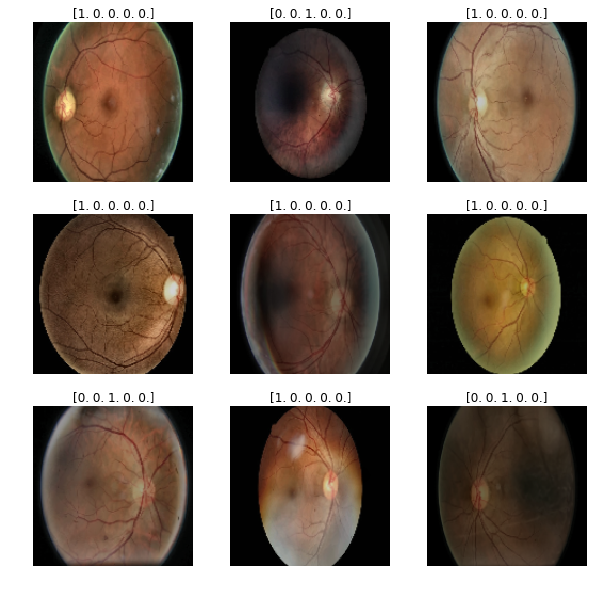

In [5]:
# Observamos un grupo de estas fotos:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  label = label_batch[i]
  plt.title(label)
  plt.axis("off")

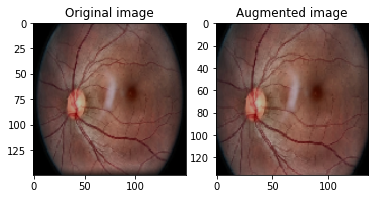

In [6]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original.astype("uint8"))

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented.numpy().astype("uint8"))
  
image_batch, label = next(iter(train_ds))
i = 1
cropped = tf.image.central_crop(image_batch[i], central_fraction=0.9)
visualize(image_batch[1], cropped)

In [7]:
import tensorflow.keras.backend as K
from tensorflow.keras.losses import CategoricalCrossentropy


class WeightedCategoricalCrossentropy(CategoricalCrossentropy):

    def __init__(self, cost_mat=np.ones((5, 5)), name='weighted_categorical_crossentropy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])

        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)

    def __call__(self, y_true, y_pred, sample_weight=None):

        return super().__call__(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )
        
    def get_config(self):
        return super().get_config().copy().update(
            {'cost_mat': self.cost_mat}
        )
    #def get_config(self):
    #    return {'cost_mat': self.cost_mat}
        
    @classmethod
    def from_config(cls, config):
       return cls(**config)


def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Categorical accuracy:
from tensorflow.keras.metrics import CategoricalAccuracy


class WeightedCategoricalAccuracy(CategoricalAccuracy):

    def __init__(self, cost_mat=np.ones((5, 5)), name='weighted_categorical_accuracy', **kwargs):
        assert(cost_mat.ndim == 2)
        assert(cost_mat.shape[0] == cost_mat.shape[1])

        super().__init__(name=name, **kwargs)
        self.cost_mat = K.cast_to_floatx(cost_mat)

    def update_state(self, y_true, y_pred, sample_weight=None):

        return super().update_state(
            y_true=y_true,
            y_pred=y_pred,
            sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
        )
#
# model.compile(metrics=[WeightedCategoricalAccuracy(cost_matrix), ...], ...)

# Matriz de costos: 
import numpy as np
w_array = np.ones((5, 5))
# If >1 - it penalize Class i classified as j
i = 0
j = 1 
w_array[i, j] = 1
# Overall enphasis in class i:
w_array[1, :] = 10 #10
w_array[2, :] = 5 #5
w_array[3, :] = 10 #29
w_array[4, :] = 10 #37
cost_mat = w_array
cost_mat


array([[ 1.,  1.,  1.,  1.,  1.],
       [10., 10., 10., 10., 10.],
       [ 5.,  5.,  5.,  5.,  5.],
       [10., 10., 10., 10., 10.],
       [10., 10., 10., 10., 10.]])

## Model

In [41]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_addons as tfa
base_model1 = EfficientNetB0(weights = 'imagenet', include_top=False, input_shape=(im_size1, im_size2, 3))

num_class = 5

# Add a new top layer
x = base_model1.output
#x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dropout(0.20)(x)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model1 = Model(inputs=base_model1.input, outputs=predictions)

print(model1.layers[1])
print(model1.layers[1].scale)  #0.003=1/255

# First: train only top layers
for layer in base_model1.layers:
    layer.trainable = False
    
# [f.trainable for f in model1.layers]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-3,
                decay_steps=5000,
                decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(loss=tfa.losses.WeightedKappaLoss(num_classes=5, weightage="quadratic"), 
              optimizer = opt, 
              metrics=WeightedCategoricalAccuracy(cost_mat)) 
model1.summary()

0.00392156862745098
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 150, 150, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_14 (Normalizatio  (None, 150, 150, 3)  7          ['rescaling_14[0][0]']           
 n)                                                                                               
                                                                       

In [8]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=base_dir + 'models/PretrainedNetworks/EfficientNetB0_Augm_im'+ str(im_size) +'.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir=base_dir + 'models/PretrainedNetworks/logs_EfficientNetB0_Augm_im'+ str(im_size) ),
]

In [42]:
base_model1.output

<KerasTensor: shape=(None, 5, 5, 1280) dtype=float32 (created by layer 'top_activation')>

In [43]:
# First round:
history1_model1 = model1.fit(train_ds, epochs=10, validation_data= val_ds, verbose=1,  callbacks=my_callbacks)

Epoch 1/10
138/138 [==============================] - 493s 4s/step - loss: -0.2081 - weighted_categorical_accuracy: 0.2778 - val_loss: -0.3148 - val_weighted_categorical_accuracy: 0.3025
Epoch 2/10
138/138 [==============================] - 618s 4s/step - loss: -0.3465 - weighted_categorical_accuracy: 0.2902 - val_loss: -0.3368 - val_weighted_categorical_accuracy: 0.2721
Epoch 3/10
138/138 [==============================] - 782s 6s/step - loss: -0.3990 - weighted_categorical_accuracy: 0.2980 - val_loss: -0.3822 - val_weighted_categorical_accuracy: 0.3052
Epoch 4/10
138/138 [==============================] - 394s 3s/step - loss: -0.3912 - weighted_categorical_accuracy: 0.2918 - val_loss: -0.5064 - val_weighted_categorical_accuracy: 0.3070
Epoch 5/10
138/138 [==============================] - 353s 3s/step - loss: -0.4205 - weighted_categorical_accuracy: 0.3010 - val_loss: -0.4047 - val_weighted_categorical_accuracy: 0.2972
Epoch 6/10
138/138 [==============================] - 377s 3s/ste

In [44]:

df_init = {
    'loss': [0.0],
    'weighted_categorical_accuracy': [0.0],
    'val_loss': [0.0], 
    'val_weighted_categorical_accuracy': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

i = 1
dic = history1_model1.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB0_Augm_im'+ str(im_size) + '.csv' )

In [ ]:
import matplotlib.pyplot as plt
history = history1_model1
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['weighted_categorical_accuracy'])
plt.plot(history.history['val_weighted_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [46]:
i = 2

# Second round:
Hresults = model1.fit(train_ds, epochs=35, initial_epoch=10, validation_data= val_ds, verbose=1, batch_size=32, callbacks=my_callbacks)
dic = Hresults.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB0_Augm_im'+ str(im_size) + '.csv' )

Epoch 11/35
138/138 [==============================] - 342s 2s/step - loss: -0.4633 - weighted_categorical_accuracy: 0.3061 - val_loss: -0.3673 - val_weighted_categorical_accuracy: 0.2894
Epoch 12/35
138/138 [==============================] - 348s 3s/step - loss: -0.4629 - weighted_categorical_accuracy: 0.3089 - val_loss: -0.3365 - val_weighted_categorical_accuracy: 0.2792
Epoch 13/35
138/138 [==============================] - 341s 2s/step - loss: -0.5000 - weighted_categorical_accuracy: 0.3068 - val_loss: -0.4474 - val_weighted_categorical_accuracy: 0.3002
Epoch 14/35
138/138 [==============================] - 340s 2s/step - loss: -0.4658 - weighted_categorical_accuracy: 0.3043 - val_loss: -0.5007 - val_weighted_categorical_accuracy: 0.3048
Epoch 15/35
138/138 [==============================] - 343s 2s/step - loss: -0.4621 - weighted_categorical_accuracy: 0.3079 - val_loss: -0.5397 - val_weighted_categorical_accuracy: 0.3032
Epoch 16/35
138/138 [==============================] - 342s 

In [ ]:
import matplotlib.pyplot as plt
history = Hresults
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['weighted_categorical_accuracy'])
plt.plot(history.history['val_weighted_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
i = 3

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=1e-5,
                decay_steps=500,
                decay_rate=0.9)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(loss=tfa.losses.WeightedKappaLoss(num_classes=5, weightage="quadratic"), 
              optimizer = opt, 
              metrics=WeightedCategoricalAccuracy(cost_mat)) 
model1.summary()

# Second round:
Hresults = model1.fit(train_ds, epochs=45, initial_epoch=35, validation_data= val_ds, verbose=1, batch_size=128, callbacks=my_callbacks)
dic = Hresults.history
df_model = pd.DataFrame(dic)
df_model['bucket'] = i
df_model
results = results.append(df_model)
results.to_csv(base_dir + 'models/PretrainedNetworks/HistResult_EfficientNetB0_Augm_im'+ str(im_size) + '.csv' )

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_14 (Rescaling)       (None, 150, 150, 3)  0           ['input_15[0][0]']               
                                                                                                  
 normalization_14 (Normalizatio  (None, 150, 150, 3)  7          ['rescaling_14[0][0]']           
 n)                                                                                               
                                                                                           